In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-40-semi-final/outlets_data.csv
/kaggle/input/data-storm-40-semi-final/data-dictionary.xlsx
/kaggle/input/data-storm-40-semi-final/product_data.csv
/kaggle/input/data-storm-40-semi-final/freezer_data.csv
/kaggle/input/data-storm-40-semi-final/week_data.csv
/kaggle/input/data-storm-40-semi-final/sales_data.csv


In [3]:
import pandas as pd

# Read data dictionary
data_dict = pd.read_excel('/kaggle/input/data-storm-40-semi-final/data-dictionary.xlsx', sheet_name='Sheet')

# Read freezer data
freezer_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/freezer_data.csv')

# Read outlets data
outlets_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/outlets_data.csv')

# Read product data
product_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/product_data.csv')

# Read sales data
sales_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/sales_data.csv')

# Read week data
week_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/week_data.csv')

In [4]:
outlets_data['Outlet_ID'] = outlets_data['Outlet_ID'].str[2:].astype(int)

sales_data['Outlet_ID'] = sales_data['Outlet_ID'].str[2:].astype(int)

In [5]:
# Merge sales_data and product_data on pid column
sales_with_product_data = pd.merge(sales_data, product_data[['pid', 'volume', 'price']], on='pid', how='left')
print(sales_with_product_data.head())

# Create a new column "sales" by multiplying price and no_units columns
sales_with_product_data['tot_sales'] = sales_with_product_data['price'] * sales_with_product_data['no_units']
# Create a new column "sales" by multiplying price and no_units columns
sales_with_product_data['tot_volume'] = sales_with_product_data['volume'] * sales_with_product_data['no_units']
print(sales_with_product_data.head())

   Outlet_ID  week  pid              product_name  no_units  volume  price
0       7203     1  IP1         Vanilla Mini Cone     874.0     0.2    100
1       7203     1  IP2      Chocolate Petite Bar     105.0     0.2     90
2       7203     1  IP3       Strawberry Tiny Cup    1198.0     0.2    110
3       7203     1  IP4        Mint Bite-size Pop     502.0     0.2    100
4       7203     1  IP5  Butter Pecan Small Stick     710.0     0.2    100
   Outlet_ID  week  pid              product_name  no_units  volume  price  \
0       7203     1  IP1         Vanilla Mini Cone     874.0     0.2    100   
1       7203     1  IP2      Chocolate Petite Bar     105.0     0.2     90   
2       7203     1  IP3       Strawberry Tiny Cup    1198.0     0.2    110   
3       7203     1  IP4        Mint Bite-size Pop     502.0     0.2    100   
4       7203     1  IP5  Butter Pecan Small Stick     710.0     0.2    100   

   tot_sales  tot_volume  
0    87400.0       174.8  
1     9450.0        21.0  


In [6]:
# Group the outlets_sales_data by Outlet_ID and calculate the total items, total units, and total weeks
outlets_data_aggregated = sales_with_product_data.groupby('Outlet_ID').agg(
    {
        'tot_sales': 'sum',
        'tot_volume': 'sum',
    }
)
# Rename the columns
outlets_data_aggregated = outlets_data_aggregated.rename(
    columns={
        'tot_sales': 'total_sales',
        'tot_volume': 'total_volume',
    }
)
# Reset the index to make Outlet_ID a regular column
outlets_data_aggregated = outlets_data_aggregated.reset_index()
# Merge the sales data with the outlets data on Outlet_ID
outlets_data_aggregated = pd.merge(outlets_data, outlets_data_aggregated, on='Outlet_ID', how='left')
print(outlets_data_aggregated.head())

   Outlet_ID  area(sqft)  total_sales  total_volume
0       7203        5660    3492920.0        6949.2
1       1878        4138    3606340.0        7208.0
2       1740        5546    3755910.0        7517.4
3       4366        5134    4060130.0        8060.8
4       8358        4100    3918700.0        7875.6


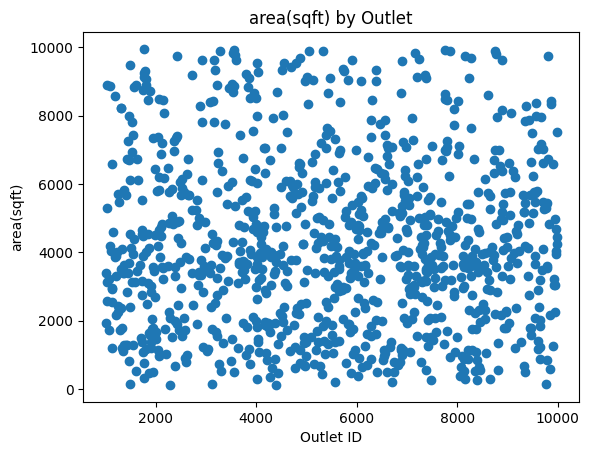

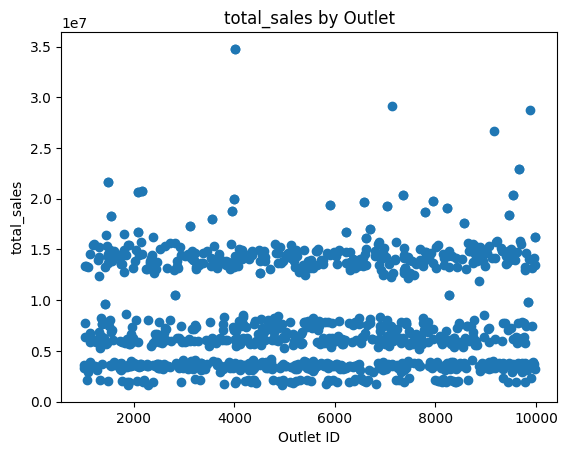

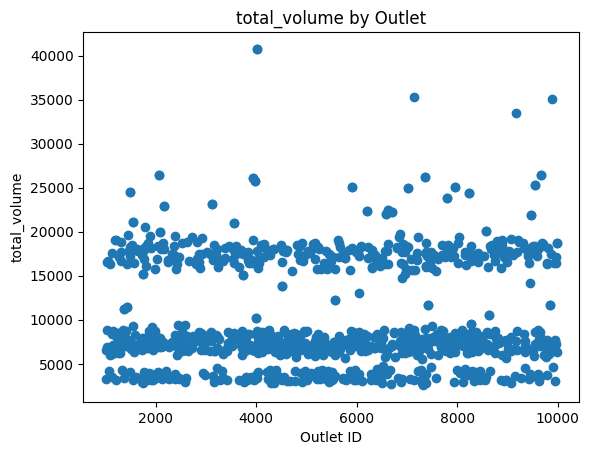

In [7]:
import matplotlib.pyplot as plt

# Create a list of column names to plot
cols_to_plot = list(outlets_data_aggregated.columns)
cols_to_plot.remove('Outlet_ID')

# Loop over each column and create a scatter plot
for col in cols_to_plot:
    # Create a new DataFrame containing the Outlet_ID and the current column
    data_to_plot = outlets_data_aggregated[['Outlet_ID', col]]
    # Create a scatter plot of the current column for each outlet
    plt.scatter(data_to_plot['Outlet_ID'], data_to_plot[col])
    # Add axis labels and a title to the plot
    plt.xlabel('Outlet ID')
    plt.ylabel(col)
    plt.title(f'{col} by Outlet')
    # Show the plot
    plt.show()

   Outlet_ID  area(sqft)  total_sales  total_volume  cluster
0       7203        5660    3492920.0        6949.2        0
1       1878        4138    3606340.0        7208.0        0
2       1740        5546    3755910.0        7517.4        0
3       4366        5134    4060130.0        8060.8        0
4       8358        4100    3918700.0        7875.6        0


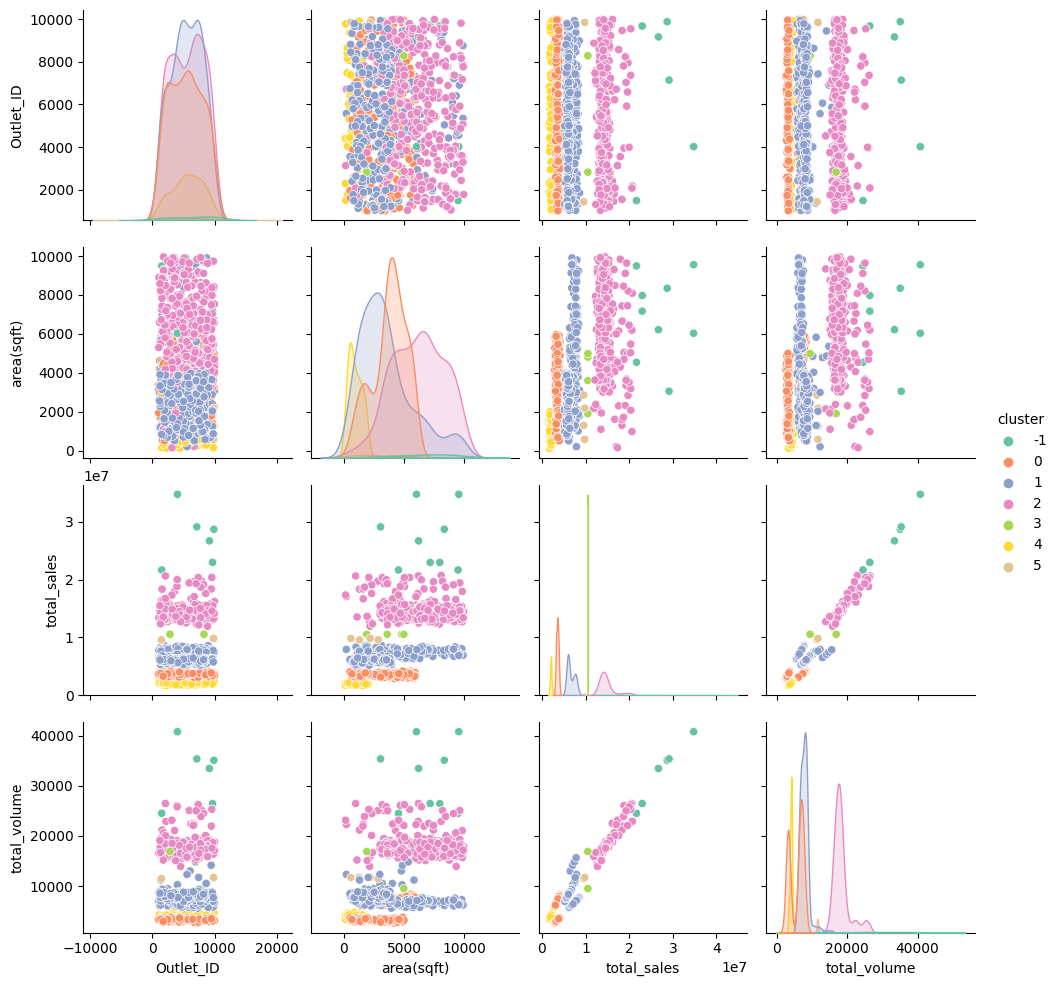

In [8]:
from sklearn.cluster import DBSCAN
# Create the DBSCAN model and fit it on the sales data
dbscan_model = DBSCAN(eps=500000, min_samples=3).fit(outlets_data_aggregated)
outlets_data_with_cluters = outlets_data_aggregated.copy()
# Add the cluster labels to the outlets_data_with_location DataFrame
outlets_data_with_cluters['cluster'] = dbscan_model.labels_
print(outlets_data_with_cluters.head())
import seaborn as sns
# Plot pairplot with hue in cluster
sns.pairplot(outlets_data_with_cluters, hue='cluster', palette='Set2')

In [9]:
from sklearn.metrics import silhouette_score
silhouette_score(outlets_data_aggregated, dbscan_model.labels_)

0.6384004528235326

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-40-semi-final/outlets_data.csv
/kaggle/input/data-storm-40-semi-final/data-dictionary.xlsx
/kaggle/input/data-storm-40-semi-final/product_data.csv
/kaggle/input/data-storm-40-semi-final/freezer_data.csv
/kaggle/input/data-storm-40-semi-final/week_data.csv
/kaggle/input/data-storm-40-semi-final/sales_data.csv


In [12]:
import pandas as pd

# Read data dictionary
data_dict = pd.read_excel('/kaggle/input/data-storm-40-semi-final/data-dictionary.xlsx', sheet_name='Sheet')

# Read freezer data
freezer_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/freezer_data.csv')

# Read outlets data
outlets_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/outlets_data.csv')

# Read product data
product_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/product_data.csv')

# Read sales data
sales_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/sales_data.csv')

# Read week data
week_data = pd.read_csv('/kaggle/input/data-storm-40-semi-final/week_data.csv')

In [13]:
outlets_data['Outlet_ID'] = outlets_data['Outlet_ID'].str[2:].astype(int)

sales_data['Outlet_ID'] = sales_data['Outlet_ID'].str[2:].astype(int)

In [14]:
# Merge sales_data and product_data on pid column
sales_with_product_data = pd.merge(sales_data, product_data[['pid', 'volume', 'price']], on='pid', how='left')
print(sales_with_product_data.head())

# Create a new column "sales" by multiplying price and no_units columns
sales_with_product_data['tot_sales'] = sales_with_product_data['price'] * sales_with_product_data['no_units']
# Create a new column "sales" by multiplying price and no_units columns
sales_with_product_data['tot_volume'] = sales_with_product_data['volume'] * sales_with_product_data['no_units']
print(sales_with_product_data.head())

   Outlet_ID  week  pid              product_name  no_units  volume  price
0       7203     1  IP1         Vanilla Mini Cone     874.0     0.2    100
1       7203     1  IP2      Chocolate Petite Bar     105.0     0.2     90
2       7203     1  IP3       Strawberry Tiny Cup    1198.0     0.2    110
3       7203     1  IP4        Mint Bite-size Pop     502.0     0.2    100
4       7203     1  IP5  Butter Pecan Small Stick     710.0     0.2    100
   Outlet_ID  week  pid              product_name  no_units  volume  price  \
0       7203     1  IP1         Vanilla Mini Cone     874.0     0.2    100   
1       7203     1  IP2      Chocolate Petite Bar     105.0     0.2     90   
2       7203     1  IP3       Strawberry Tiny Cup    1198.0     0.2    110   
3       7203     1  IP4        Mint Bite-size Pop     502.0     0.2    100   
4       7203     1  IP5  Butter Pecan Small Stick     710.0     0.2    100   

   tot_sales  tot_volume  
0    87400.0       174.8  
1     9450.0        21.0  


In [15]:
# Group the outlets_sales_data by Outlet_ID and calculate the total items, total units, and total weeks
outlets_data_aggregated = sales_with_product_data.groupby('Outlet_ID').agg(
    {
        'tot_sales': 'sum',
        'tot_volume': 'sum',
        'no_units': 'sum',
    }
)
# Rename the columns
outlets_data_aggregated = outlets_data_aggregated.rename(
    columns={
        'tot_sales': 'total_sales',
        'tot_volume': 'total_volume',
        'no_units': 'total_units',
    }
)
# Reset the index to make Outlet_ID a regular column
outlets_data_aggregated = outlets_data_aggregated.reset_index()
# Merge the sales data with the outlets data on Outlet_ID
outlets_data_aggregated = pd.merge(outlets_data, outlets_data_aggregated, on='Outlet_ID', how='left')
print(outlets_data_aggregated.head())

# # Revenue per unit sold
# outlets_data_aggregated['sales_per_unit'] = outlets_data_aggregated['total_sales'] / outlets_data_aggregated['total_units']
# # Revenue per unit volume
# outlets_data_aggregated['sales_per_unit_volume'] = outlets_data_aggregated['total_sales'] / outlets_data_aggregated['total_volume']

cols = outlets_data_aggregated.columns
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(outlets_data_aggregated)
outlets_data_scaled = transformer.transform(outlets_data_aggregated)
outlets_data_scaled = pd.DataFrame(outlets_data_scaled, columns=cols)
print(outlets_data_scaled.head())

   Outlet_ID  area(sqft)  total_sales  total_volume  total_units
0       7203        5660    3492920.0        6949.2      34746.0
1       1878        4138    3606340.0        7208.0      36040.0
2       1740        5546    3755910.0        7517.4      37587.0
3       4366        5134    4060130.0        8060.8      40304.0
4       8358        4100    3918700.0        7875.6      39378.0
   Outlet_ID  area(sqft)  total_sales  total_volume  total_units
0   0.387756    0.484723    -0.286025     -0.087352     0.088422
1  -0.870886    0.051136    -0.274651     -0.062281     0.130265
2  -0.903504    0.452247    -0.259653     -0.032308     0.180288
3  -0.282810    0.334876    -0.229147      0.020334     0.268144
4   0.660758    0.040311    -0.243329      0.002393     0.238201


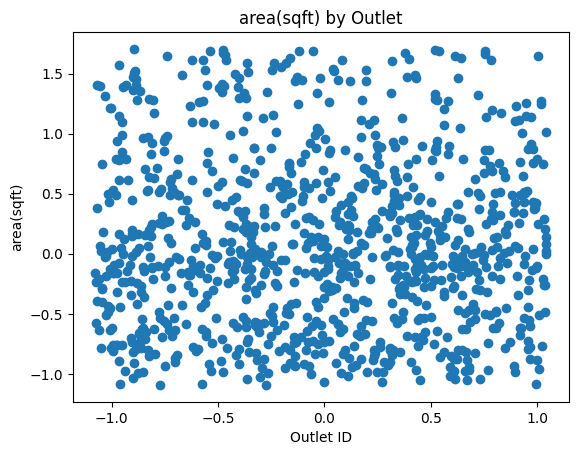

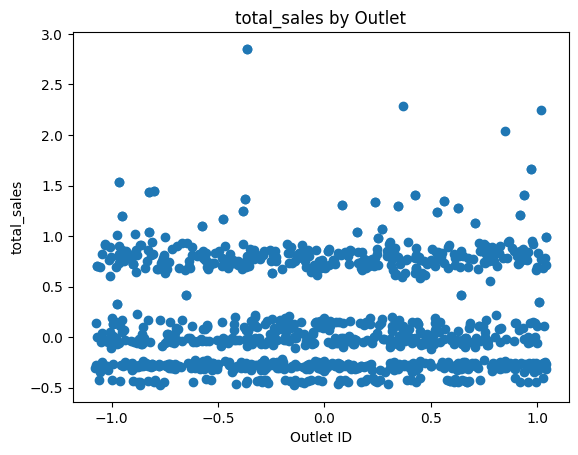

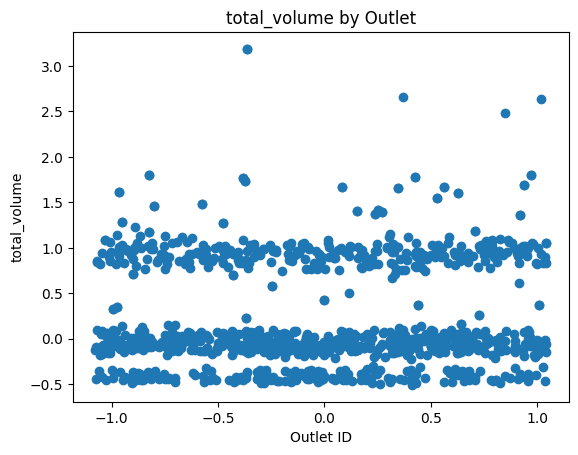

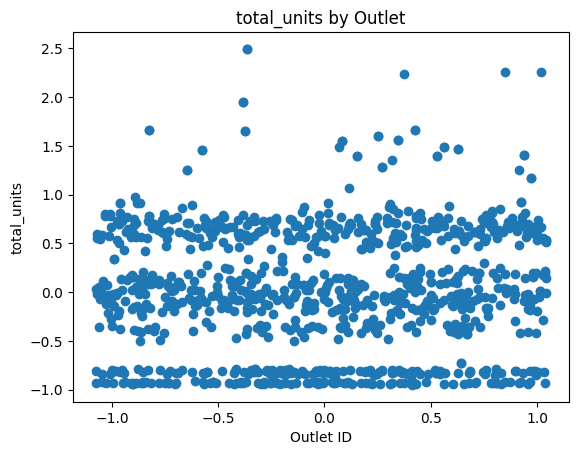

In [16]:
import matplotlib.pyplot as plt

# Create a list of column names to plot
cols_to_plot = list(outlets_data_scaled.columns)
cols_to_plot.remove('Outlet_ID')

# Loop over each column and create a scatter plot
for col in cols_to_plot:
    # Create a new DataFrame containing the Outlet_ID and the current column
    data_to_plot = outlets_data_scaled[['Outlet_ID', col]]
    # Create a scatter plot of the current column for each outlet
    plt.scatter(data_to_plot['Outlet_ID'], data_to_plot[col])
    # Add axis labels and a title to the plot
    plt.xlabel('Outlet ID')
    plt.ylabel(col)
    plt.title(f'{col} by Outlet')
    # Show the plot
    plt.show()

In [17]:
outlets_data_scaled = outlets_data_scaled.drop(['Outlet_ID', 'area(sqft)'], axis=1)
print(outlets_data_scaled.head())

   total_sales  total_volume  total_units
0    -0.286025     -0.087352     0.088422
1    -0.274651     -0.062281     0.130265
2    -0.259653     -0.032308     0.180288
3    -0.229147      0.020334     0.268144
4    -0.243329      0.002393     0.238201


(988, 20)
(88,)


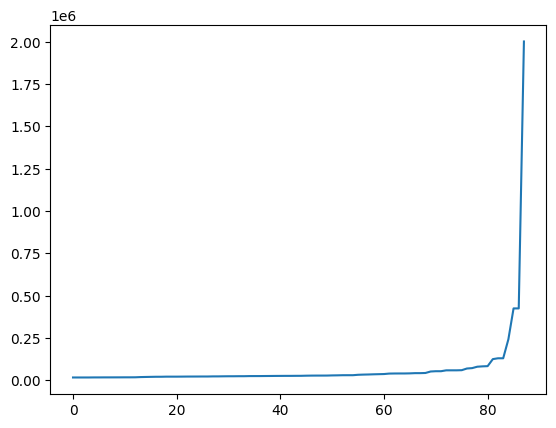

In [18]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(outlets_data_aggregated)
distances, indices = neighbors_fit.kneighbors(outlets_data_aggregated)
distances = np.sort(distances, axis=0)
print(distances.shape)
distances = distances[:,1]
distances = distances[900:990]
print(distances.shape)
plt.plot(distances)

   total_sales  total_volume  total_units  cluster
0    -0.286025     -0.087352     0.088422        0
1    -0.274651     -0.062281     0.130265        0
2    -0.259653     -0.032308     0.180288        0
3    -0.229147      0.020334     0.268144        0
4    -0.243329      0.002393     0.238201        0


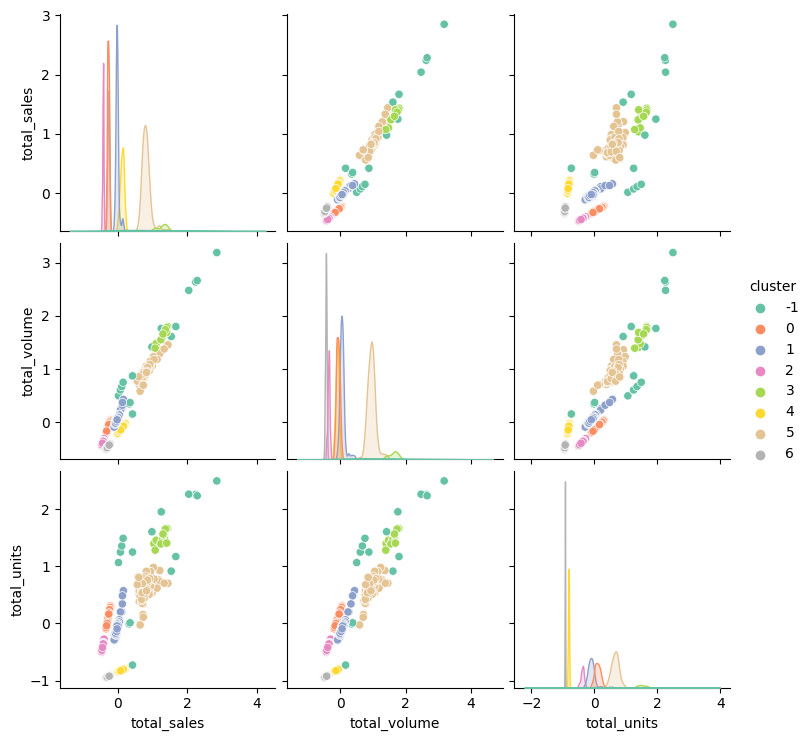

In [19]:
from sklearn.cluster import DBSCAN
# Create the DBSCAN model and fit it on the sales data
dbscan_model = DBSCAN(eps=0.2, min_samples=5).fit(outlets_data_scaled)
outlets_data_with_clusters = outlets_data_scaled.copy()
# Add the cluster labels to the outlets_data_with_location DataFrame
outlets_data_with_clusters['cluster'] = dbscan_model.labels_
print(outlets_data_with_clusters.head())
import seaborn as sns
# Plot pairplot with hue in cluster
sns.pairplot(outlets_data_with_clusters, hue='cluster', palette='Set2')

In [20]:
import plotly.express as px
df = outlets_data_with_clusters
fig = px.scatter_3d(df, x='total_sales', y='total_volume', z='total_units', color='cluster')
fig.show()

In [21]:
from sklearn.metrics import silhouette_score
silhouette_score(outlets_data_scaled, dbscan_model.labels_)

0.7218670653154697

In [22]:
outlets_data_aggregated['cluster'] = outlets_data_with_clusters['cluster']
outlets_data_aggregated = outlets_data_aggregated.drop(['Outlet_ID', 'area(sqft)'], axis=1)

In [23]:
grps=outlets_data_aggregated.groupby('cluster')

for i in grps:
    print(i[0])
    print(i[1].describe().T)

-1
              count          mean           std        min        25%  \
total_sales    25.0  1.691730e+07  8.896373e+06  6488470.0  9817490.0   
total_volume   25.0  2.162758e+04  9.796685e+03     9466.0    12989.6   
total_units    25.0  6.818352e+04  2.934169e+04     9466.0    60313.0   
cluster        25.0 -1.000000e+00  0.000000e+00       -1.0       -1.0   

                     50%         75%         max  
total_sales   16113850.0  22981250.0  34775130.0  
total_volume     22480.6     26425.0     40760.0  
total_units      70644.0     92431.0    109168.0  
cluster             -1.0        -1.0        -1.0  
0
              count          mean            std        min        25%  \
total_sales   161.0  3.503442e+06  269226.103058  2904230.0  3286090.0   
total_volume  161.0  7.005296e+03     535.668569     5826.8     6579.8   
total_units   161.0  3.502648e+04    2678.342846    29134.0    32899.0   
cluster       161.0  0.000000e+00       0.000000        0.0        0.0   

   

In [24]:
sales_with_product_data['outlet_week'] = sales_with_product_data.apply(lambda x: f"{x['Outlet_ID']}-{x['week']}", axis=1)
outlets_by_week = sales_with_product_data.groupby('outlet_week').agg(weekly_volume=pd.NamedAgg(column="tot_volume", aggfunc="sum"), weekly_sales=pd.NamedAgg(column="tot_sales", aggfunc="sum"))
outlets_by_week = outlets_by_week.reset_index()
outlets_by_week['outlet_week'] = outlets_by_week['outlet_week'].astype(str)
outlets_by_week['Outlet_ID'] = [x.split("-")[0] for x in outlets_by_week['outlet_week'].values.tolist()]
outlets_by_week['Outlet_ID'] = outlets_by_week['Outlet_ID'].str[2:].astype(int)
outlets_by_week['week'] = [x.split("-")[1] for x in outlets_by_week['outlet_week'].values.tolist()]

sales_by_outlet = outlets_by_week.groupby('Outlet_ID').agg(median_volume=pd.NamedAgg(column="weekly_volume", aggfunc="median"),
                                                           max_volume=pd.NamedAgg(column="weekly_volume", aggfunc="max"))
sales_by_outlet['median_volume_per_day'] = sales_by_outlet['median_volume']/7
sales_by_outlet['max_volume_per_day'] = sales_by_outlet['max_volume']/7

In [25]:
outlets_data_with_clusters['Outlet_ID'] = outlets_data['Outlet_ID']
outlets_data_with_clusters = outlets_data_with_clusters.merge(sales_by_outlet, on='Outlet_ID', how='left')
# Calculate the ROI for each freezer for each cluster
for cluster in np.sort(outlets_data_with_clusters['cluster'].unique()):
    # Select the rows from the DataFrame that belong to the specified cluster
    cluster_data = outlets_data_with_clusters[outlets_data_with_clusters['cluster'] == cluster]
    # Get the IDs of the outlets in the selected cluster
    cluster_outlet_ids = cluster_data.index.tolist()
    # Select the rows from the DataFrame that correspond to the selected outlets
    selected_outlets_data = outlets_data_aggregated.loc[cluster_outlet_ids]
    # Calculate the total ice cream sales for the cluster
    total_sales = selected_outlets_data['total_sales'].sum()
    # Calculate the total ice cream volume for the cluster
    total_volume = selected_outlets_data['total_volume'].sum()
    # Calculate the volume_ratio for the cluster
    volume_ratio = sales_by_outlet['median_volume_per_day'].median() / freezer_data['Volume Capacity (Liters)']
    volume_ratio = np.ceil(volume_ratio)
    print(volume_ratio)
    # Calculate the ROI for each freezer in the freezer data
    freezer_data['ROI'] = total_sales / ((freezer_data['Volume Capacity (Liters)'] * 250 + freezer_data['Power and maitainance Cost (LKR) per 100 hours'] * 0.24) * volume_ratio)
    # Select the freezer with the highest ROI for the cluster
    best_freezer = freezer_data.loc[freezer_data['ROI'].idxmax()]
    # Print the result
    print(f"Cluster {cluster: >2}: Best freezer is {best_freezer['Freezer Name']} (Model {best_freezer['Model Number']}) with an ROI of {best_freezer['ROI']:.2f}")

0    2.0
1    2.0
2    1.0
3    4.0
4    1.0
5    2.0
6    1.0
7    4.0
8    2.0
9    1.0
Name: Volume Capacity (Liters), dtype: float64
Cluster -1: Best freezer is FreezeTech  (Model M007) with an ROI of 16443.72
0    2.0
1    2.0
2    1.0
3    4.0
4    1.0
5    2.0
6    1.0
7    4.0
8    2.0
9    1.0
Name: Volume Capacity (Liters), dtype: float64
Cluster  0: Best freezer is FreezeTech  (Model M007) with an ROI of 21930.57
0    2.0
1    2.0
2    1.0
3    4.0
4    1.0
5    2.0
6    1.0
7    4.0
8    2.0
9    1.0
Name: Volume Capacity (Liters), dtype: float64
Cluster  1: Best freezer is FreezeTech  (Model M007) with an ROI of 44035.31
0    2.0
1    2.0
2    1.0
3    4.0
4    1.0
5    2.0
6    1.0
7    4.0
8    2.0
9    1.0
Name: Volume Capacity (Liters), dtype: float64
Cluster  2: Best freezer is FreezeTech  (Model M007) with an ROI of 5483.54
0    2.0
1    2.0
2    1.0
3    4.0
4    1.0
5    2.0
6    1.0
7    4.0
8    2.0
9    1.0
Name: Volume Capacity (Liters), dtype: float64
Cluster 

In [26]:
bins = [0, 25, 30, 55, 65, 75, 80, 100, 120, 150, 200]    #freezer_data['Volume Capacity (Liters)'].values.tolist().insert(0,0)
labels = freezer_data['Model Number'].values.tolist()    #[0, 25, 30, 55, 65, 75, 80, 100, 120, 150, 200]

def find_bin(x, bins):
    for i in range(len(bins)-1):
        if x <= bins[i+1]:
            return i
    return len(bins)-2

outlets_data_with_clusters['Outlet_ID'] = outlets_data['Outlet_ID']
outlets_data_with_clusters = outlets_data_with_clusters.merge(sales_by_outlet, on='Outlet_ID', how='left')
# Calculate the ROI for each freezer for each cluster
for cluster in np.sort(outlets_data_with_clusters['cluster'].unique()):
    # Select the rows from the DataFrame that belong to the specified cluster
    cluster_data = outlets_data_with_clusters[outlets_data_with_clusters['cluster'] == cluster]
    # Get the IDs of the outlets in the selected cluster
    cluster_outlet_ids = cluster_data.index.tolist()
    # Select the rows from the DataFrame that correspond to the selected outlets
    selected_outlets_data = outlets_data_aggregated.loc[cluster_outlet_ids]
    # Calculate the 85th percentile value of volume for the cluster
    percentile_85 = selected_outlets_data['total_volume'].quantile(q=0.85) / 84
    print(percentile_85)
    best_freezer = labels[find_bin(percentile_85, bins)]
    print(f"Cluster {cluster: >2}: Best freezer is {best_freezer}")

405.76142857142855
Cluster -1: Best freezer is M010
90.49285714285715
Cluster  0: Best freezer is M007
104.28
Cluster  1: Best freezer is M008
51.2522619047619
Cluster  2: Best freezer is M003
309.81333333333333
Cluster  3: Best freezer is M010
85.94761904761906
Cluster  4: Best freezer is M007
222.7509523809524
Cluster  5: Best freezer is M010
40.85
Cluster  6: Best freezer is M003
